<a href="https://colab.research.google.com/github/ritiksharmasde/Deep_Learning/blob/main/Final_Orbit_Trajectory_finder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# Load dataset without any normalization...
data = pd.read_csv('cleaned_dates.csv')
# Select features (positions & velocities), i didn't do any further
#feature engineering...
features = data[['X', 'Y', 'Z', 'VX', 'VY', 'VZ']].values

# Z-score normalization ( i wanted not to reduce significance of negative sign...)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Past sequence
        y.append(data[i + seq_length])    # Next timestep
    return np.array(X), np.array(y)

seq_length = 7  # Number of past steps to look at
X, y = create_sequences(scaled_features, seq_length)

# Split into train & test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define improved LSTM model
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_length, X.shape[2])))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(X.shape[2]))

# Compile model
model.compile(optimizer='adam', loss='mse')
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Function to predict future positions
def predict_future(model, last_sequence, n_steps, scaler):
    future = []
    current_seq = last_sequence.copy()

    for _ in range(n_steps):
        pred = model.predict(current_seq.reshape(1, seq_length, X.shape[2]), verbose=0)
        future.append(pred[0])

        # Corrected sequence update
        current_seq[:-1] = current_seq[1:]
        current_seq[-1] = pred[0]


    future = np.array(future)

    print("Scaled Predictions (First 5 rows):\n", future[:5])

    future_real = scaler.inverse_transform(future)

    print("Real-World Predictions (First 5 rows):\n", future_real[:5])

    return future_real

# Predict next 365 steps using last test sequence
last_sequence = X_test[-1]
future_steps = 365
predictions = predict_future(model, last_sequence, future_steps, scaler)

# Save predictions
pred_df = pd.DataFrame(predictions, columns=['Pred_X', 'Pred_Y', 'Pred_Z', 'Pred_VX', 'Pred_VY', 'Pred_VZ'])
pred_df.to_csv('predicted_orbit.csv', index=False)

print("Predicted future positions saved as predicted_orbit.csv")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.4711 - val_loss: 0.0805
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0532 - val_loss: 0.0475
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0417 - val_loss: 0.0413
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0353 - val_loss: 0.0336
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0276 - val_loss: 0.0260
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0197 - val_loss: 0.0106
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0559e-04 - val_loss: 0.0033
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.5178e-04 - val_loss: 0.0022
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.0014e-04 - val_loss: 0.0023
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.0452e-04 - val_loss: 0.0023
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━

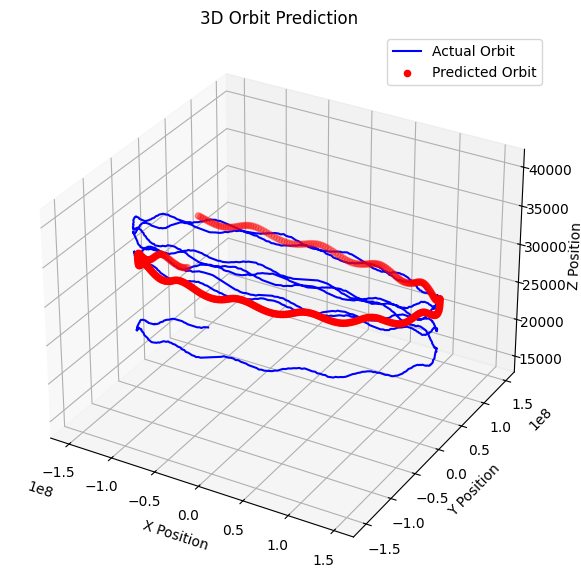

In [3]:

# Load actual data
data = pd.read_csv('cleaned_dates.csv')
actual_x = data['X']
actual_y = data['Y']
actual_z = data['Z']

# Load predicted data
pred_df = pd.read_csv('predicted_orbit.csv')
pred_x = pred_df['Pred_X']
pred_y = pred_df['Pred_Y']
pred_z = pred_df['Pred_Z']

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot actual orbit in blue
ax.plot(actual_x, actual_y, actual_z, label="Actual Orbit", color='blue')

# Plot predicted orbit in red
ax.scatter(pred_x, pred_y, pred_z, label="Predicted Orbit", color='red', marker='o')

# Labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Orbit Prediction')

# Show legend
ax.legend()

# Show plot
plt.show()


In [4]:

# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions & actual values to original scale
y_pred_original = y_pred
y_test_original = y_test

# Compute accuracy metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# Print results
print(f"Model Evaluation on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Model Evaluation on Test Data:
Mean Absolute Error (MAE): 0.0224
Mean Squared Error (MSE): 0.0021
Root Mean Squared Error (RMSE): 0.0460
R² Score: 0.9976


In [5]:
model.save('original_LSTM_Earth_Model.h5')